# Setup

## Imports

In [49]:
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest
import seaborn as sns

## Constants

In [50]:
# Generalized Deduplication
DEVIATION_BITS = 5

# Isolation Forest
rng = np.random.RandomState(42)

# Performance
time_no_iterations = 50
time_no_outliers_removed = 5

# Load Data

## Generate data

In [51]:
from scipy.io import arff
from sklearn.model_selection import train_test_split

data = arff.loadarff('./data/PenDigits/PenDigits_withoutdupl_norm_v10.arff')
df = pd.DataFrame(data[0])
df['outlier'].mask(df['outlier'] == b'no', 1, inplace=True)
df['outlier'].mask(df['outlier'] == b'yes', -1, inplace=True)
y = df.pop('outlier').values.astype(int)
id = df.pop('id')
df = df.astype(int)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rng)

## Perform Generalized Deduplication

In [52]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")
X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

# Model Training

## Setup

In [53]:
gd_df_results = pd.DataFrame()
gd_ext_df_results = pd.DataFrame()
org_df_results = pd.DataFrame()
performance = pd.DataFrame(columns=['name', 'deviation_bits', 'train_accuracy_score', 'test_accuracy_score', 'outlier_accuracy_score', 'train_precision_score', 'test_precision_score', 'outlier_precision_score','train_f1_score', 'test_f1_score', 'outlier_f1_score',
  'train_recall_score', 'test_recall_score', 'outlier_recall_score',
  'train_roc_auc_score', 'test_roc_auc_score', 'outlier_roc_auc_score', 'training_time', 'prediction_time'])


def create_performance_object(name, deviation_bits, y_pred_train, y_pred_test, training_time, prediction_time, test_accuracy_score, test_f1_score, test_recall_score, test_roc_auc_score):
    return {
    'name': name,
    'deviation_bits': deviation_bits,
    'train_accuracy_score': accuracy_score(y_train, y_pred_train),
    'test_accuracy_score': test_accuracy_score,
    'train_precision_score': precision_score(y_train, y_pred_train),
    'test_precision_score': precision_score(y_test, y_pred_test),
    'train_f1_score': f1_score(y_train, y_pred_train),
    'test_f1_score': test_f1_score,
    'train_recall_score': recall_score(y_train, y_pred_train),
    'test_recall_score': test_recall_score,
    'train_roc_auc_score': roc_auc_score(y_train, y_pred_train),
    'test_roc_auc_score': test_roc_auc_score,
    'training_time': training_time,
    'prediction_time': prediction_time,
    }

## Isolation Forest - Bases

In [54]:
training_times = []
prediction_times = []
accuracies = []
f1s = []
recs = []
rocs = []

for i in range(0, time_no_iterations):
    gd_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    gd_clf.fit(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = gd_clf.predict(X_train_bases)
    y_pred_test = gd_clf.predict(X_test_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    accuracies.append(accuracy_score(y_test, y_pred_test))
    f1s.append(f1_score(y_test, y_pred_test))
    recs.append(recall_score(y_test, y_pred_test))
    rocs.append(roc_auc_score(y_test, y_pred_test))

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
accuracies = pd.DataFrame(accuracies)
f1s = pd.DataFrame(f1s)
recs = pd.DataFrame(recs)
rocs = pd.DataFrame(rocs)

training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)
accuracies = accuracies.drop(accuracies.nsmallest(time_no_outliers_removed, 0).index).drop(accuracies.nlargest(accuracies, 0).index)
f1s = f1s.drop(f1s.nsmallest(time_no_outliers_removed, 0).index).drop(f1s.nlargest(time_no_outliers_removed, 0).index)
recs = recs.drop(recs.nsmallest(time_no_outliers_removed, 0).index).drop(recs.nlargest(accuracies, 0).index)
rocs = rocs.drop(f1s.nsmallest(time_no_outliers_removed, 0).index).drop(rocs.nlargest(time_no_outliers_removed, 0).index)


performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), rocs[0].mean()), ignore_index=True)

gd_df_results['gd_X'] = X_train_bases[:,0]
gd_df_results['gd_Y'] = X_train_bases[:,1]
gd_df_results['gd_score'] = gd_clf.decision_function(X_train_bases)

gd_df_results['gd_anomaly'] = gd_clf.predict(X_train_bases)
gd_df_results.head()
gd_clf.decision_function(X_test_bases)

/tmp/ipykernel_268456/3968961124.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


array([ 0.01042061, -0.0206708 , -0.06683306, ..., -0.03335815,
        0.0196373 , -0.02166838])

## Isolation Forest - Bases - Extended

In [55]:
training_times = []
prediction_times = []
accuracies = []
f1s = []
recs = []
rocs = []

for i in range(0, time_no_iterations):
    gd_ext_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    gd_ext_clf.fit_extended(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = gd_ext_clf.predict_extended(X_train_bases)
    y_pred_test = gd_ext_clf.predict_extended(X_test_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    accuracies.append(accuracy_score(y_test, y_pred_test))
    f1s.append(f1_score(y_test, y_pred_test))
    recs.append(recall_score(y_test, y_pred_test))
    rocs.append(roc_auc_score(y_test, y_pred_test))

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
accuracies = pd.DataFrame(accuracies)
f1s = pd.DataFrame(f1s)
recs = pd.DataFrame(recs)
rocs = pd.DataFrame(rocs)

training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)
accuracies = accuracies.drop(accuracies.nsmallest(time_no_outliers_removed, 0).index).drop(accuracies.nlargest(accuracies, 0).index)
f1s = f1s.drop(f1s.nsmallest(time_no_outliers_removed, 0).index).drop(f1s.nlargest(time_no_outliers_removed, 0).index)
recs = recs.drop(recs.nsmallest(time_no_outliers_removed, 0).index).drop(recs.nlargest(accuracies, 0).index)
rocs = rocs.drop(f1s.nsmallest(time_no_outliers_removed, 0).index).drop(rocs.nlargest(time_no_outliers_removed, 0).index)


performance = performance.append(create_performance_object('Isolation Forest Bases - extended', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), rocs[0].mean()), ignore_index=True)

gd_ext_df_results['gd_X'] = X_train_bases[:,0]
gd_ext_df_results['gd_Y'] = X_train_bases[:,1]
gd_ext_df_results['gd_score'] = gd_ext_clf.decision_function_extended(X_train_bases)
gd_ext_df_results['gd_anomaly'] = y_pred_train
gd_ext_clf.decision_function_extended(X_test_bases)

/home/mlrosenquist/PycharmProjects/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_unique_ = self.df_unique_.append(pd.DataFrame(unique), ignore_index=True)
/tmp/ipykernel_268456/2891068820.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Bases - extended', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


array([ 0.01999132, -0.04820603, -0.05677902, ..., -0.03197981,
        0.03798499, -0.02203321])

## Isolation Forest Original Data

In [56]:
training_times = []
prediction_times = []
accuracies = []
f1s = []
recs = []
rocs = []

for i in range(0, time_no_iterations):
    org_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    org_clf.fit(X_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = org_clf.predict(X_train)
    y_pred_test = org_clf.predict(X_test)
    y_pred_outliers = org_clf.predict(X_outliers)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    accuracies.append(accuracy_score(y_test, y_pred_test))
    f1s.append(f1_score(y_test, y_pred_test))
    recs.append(recall_score(y_test, y_pred_test))
    rocs.append(roc_auc_score(y_test, y_pred_test))

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
accuracies = pd.DataFrame(accuracies)
f1s = pd.DataFrame(f1s)
recs = pd.DataFrame(recs)
rocs = pd.DataFrame(rocs)

training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)
accuracies = accuracies.drop(accuracies.nsmallest(time_no_outliers_removed, 0).index).drop(accuracies.nlargest(accuracies, 0).index)
f1s = f1s.drop(f1s.nsmallest(time_no_outliers_removed, 0).index).drop(f1s.nlargest(time_no_outliers_removed, 0).index)
recs = recs.drop(recs.nsmallest(time_no_outliers_removed, 0).index).drop(recs.nlargest(accuracies, 0).index)
rocs = rocs.drop(f1s.nsmallest(time_no_outliers_removed, 0).index).drop(rocs.nlargest(time_no_outliers_removed, 0).index)

performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), rocs[0].mean()), ignore_index=True)

org_df_results['org_X'] = X_train[:,0]
org_df_results['org_Y'] = X_train[:,1]
org_df_results['org_score'] = org_clf.decision_function(X_train)
org_df_results['org_anomaly'] = org_clf.predict(X_train)
org_df_results.head()

/tmp/ipykernel_268456/774331695.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


,org_score,org_anomaly
0,-0.043169,-1
1,-0.000888,-1
2,-0.015286,-1
3,0.045590,1
4,-0.001310,-1


# Performance evaluation

## Overview

In [57]:
performance

,name,deviation_bits,train_accuracy_score,test_accuracy_score,outlier_accuracy_score,train_precision_score,test_precision_score,outlier_precision_score,train_f1_score,test_f1_score,outlier_f1_score,train_recall_score,test_recall_score,outlier_recall_score,train_roc_auc_score,test_roc_auc_score,outlier_roc_auc_score,training_time,prediction_time
0,Isolation Forest Bases,5,0.500887,0.485816,NaN,1.0,0.998955,NaN,0.666554,0.653229,NaN,0.499873,0.485279,NaN,0.749937,0.61764,NaN,0.212065,0.487317
1,Isolation Forest Bases - extended,5,0.610464,0.555218,NaN,1.0,1.0,NaN,0.757511,0.713259,NaN,0.609673,0.554315,NaN,0.804836,0.777157,NaN,0.282432,2.373455
2,Isolation Forest Original,5,0.502027,0.492908,NaN,1.0,1.0,NaN,0.667569,0.659408,NaN,0.501015,0.491878,NaN,0.750508,0.745939,NaN,0.184964,0.314539


## Confusion Matrices

/tmp/ipykernel_268456/1162717073.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


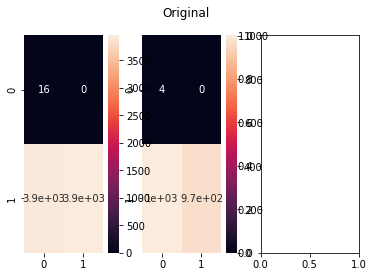

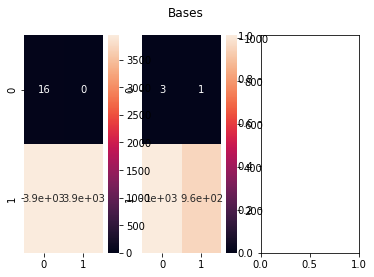

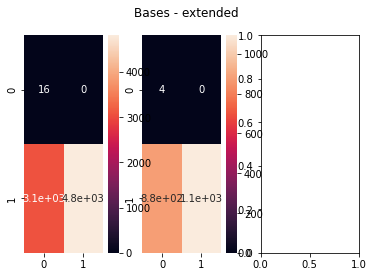

In [58]:

y_train_clipped = y_train.clip(min=0)
y_test_clipped = y_test.clip(min=0)

# Original
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Original")

y_train_pred =  org_clf.predict(X_train).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  org_clf.predict(X_test).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

# GD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases")

y_train_pred =  gd_clf.predict(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_clf.predict(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

# GD Extended
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases - extended")
y_train_pred =  gd_ext_clf.predict_extended(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_ext_clf.predict_extended(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

fig.show()

# Data Visualization

## Bases - density

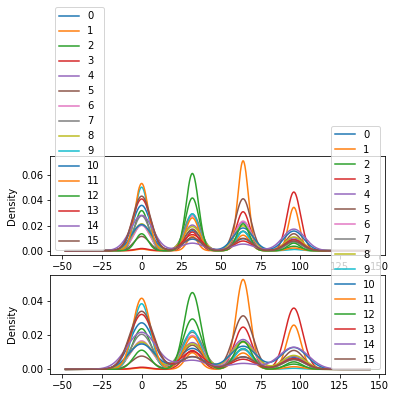

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
plt.show()